In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx
import copy
import circuits as ckt

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(0 , 1), (1 , 0)]
[(0, {}), (1, {})]
[(0, 1, 0, {'kind': 0, 'i': None, 'v': None, 'attr': 10}), (1, 0, 0, {'kind': 1, 'i': None, 'v': None, 'attr': 5})]


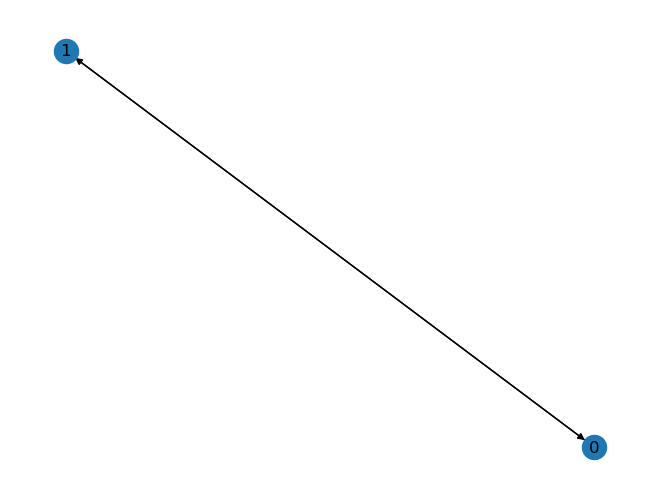

In [3]:
vr = ckt.Circuit()
v_source = vr.add_element(kind=ckt.Kinds.IVS.value)
resistor = vr.add_element(kind=ckt.Kinds.R.value)
v_source.connect(v_source.high, resistor.low)
v_source.connect(v_source.low, resistor.high)
v_source.attr = 10
resistor.attr = 5
# v_source.low.p = 0
print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Inputs

In [5]:
input_test = ckt.Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:77: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input_test.M

tensor([[-1.,  1.],
        [ 1., -1.]])

# Circuit Theory Functions

In [7]:
input_test.prop_tensors()

(tensor([[0.],
         [0.]]),
 tensor([[0.],
         [0.]]),
 tensor([[0.],
         [0.]]),
 tensor([[10.],
         [ 5.]]))

In [8]:
input_test.element_row()

tensor([[ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -5.,  0.,  1.,  0.,  0.]])

In [9]:
input_test.kind_map()

{0: tensor([[1.],
         [0.]]),
 1: tensor([[0.],
         [1.]])}

In [10]:
input_test.s()

tensor([[10.],
        [ 0.]])

# Define Models

In [11]:
class Solve(nn.Module):
    ''' 
    Sparse Tableau Formulation of circuit analysis, modeled as a machine learning
    problem to learn element attributes using backprop and optimization.
    '''
    def __init__(self, input: ckt.Input):
        super().__init__()
        self.input = input
        i_in, v_in, pot_in, attr_in = self.input.prop_tensors()
        self.attr = nn.Parameter(attr_in)

    def forward(self):
        A,b = self.build()
        print(f'A {A}')
        print(f'b {b}')
        solution = torch.linalg.lstsq(A,b).solution
        print(f'x {solution}')
        calc_attrs = self.calc_attrs(solution)
        return calc_attrs
            
    def zero_known_grads(self, attr_known):
        self.attr.grad[attr_known] = 0

    def build(self):
        # inputs
        i_in, v_in, pot_in, attr_in = self.input.prop_tensors()
        kind_map = self.input.kind_map()
        is_s_mask = kind_map[ckt.Kinds.IVS.value]
        is_r_mask = kind_map[ckt.Kinds.R.value]
        i_known, v_known, pot_known , attr_known = self.input.known_masks()
        attr_known = attr_known.to(torch.bool)
        is_r_mask_z, is_r_mask_y, is_s_mask_y = self.input.rs_mask(kind_map)
        s = self.input.s()
        M = self.input.M
        num_elements = M.shape[1]
                
        # A matrix
        kcl_row = torch.cat(tensors=(M,
                                    torch.zeros_like(M),
                                    torch.zeros_like(M)),dim=1)
        kvl_row = torch.cat(tensors=(torch.zeros_like(M),
                                    torch.eye(num_elements),
                                    -M.T),dim=1)
        e_row = self.input.element_row()
        A = torch.cat(tensors=(kcl_row,kvl_row,e_row), dim=0)

        # b matrix
        kcl_zeros = torch.zeros_like(i_in)
        kvl_zeros = torch.zeros_like(v_in)
        b = torch.cat(tensors=(kvl_zeros,kcl_zeros,s), dim=0)
        
        return A,b

    def calc_attrs(self, solution: torch.Tensor):
        kind_masks = self.input.kind_map()
        ivs_mask: torch.Tensor = kind_masks[ckt.Kinds.IVS.value].to(torch.bool)
        r_mask: torch.Tensor  = kind_masks[ckt.Kinds.R.value].to(torch.bool)
        num_elements = r_mask.shape[0]
        
        i = solution[:num_elements,:]
        v = solution[num_elements:2*num_elements,:]
        
        ret_attrs = torch.zeros(size=(num_elements,1))

        ret_attrs[ivs_mask] = v[ivs_mask]
        ret_attrs[r_mask] = i[r_mask]*v[r_mask]

        return ret_attrs

# Create Instance of Models

In [12]:
input = ckt.Input(vr)
model = Solve(input=input)
list(model.parameters())

[Parameter containing:
 tensor([[10.],
         [ 5.]], requires_grad=True)]

# Loss

In [13]:
loss_fn = nn.MSELoss()

# Optimizer

In [14]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.1)

# Train Function

# Test Function 

No inference therefore no testing!

# Run Train Loop

In [15]:
def attr_known_mask():
    _, _, _, attr_known = input.known_masks()
    attr_bool = attr_known.to(torch.bool)
    return attr_bool


In [16]:
def attr_truth():
    _, _, _, attr_in = input.prop_tensors()
    return attr_in

In [17]:
attr_truth()[attr_known_mask()]

tensor([10.,  5.])

In [18]:
epochs = 2

prev_loss = 0.1
lt_prev_loss = 1000

attr_true = attr_truth()

knowns_cat = attr_known_mask()

for t in range(epochs):

    #set training mode
    model.train()

    pred = model()
    print(pred[knowns_cat])
    print(attr_true[knowns_cat])
    loss = loss_fn(pred[knowns_cat], attr_true[knowns_cat])

    model.zero_grad()

    # loss.backward(retain_graph=True)
    loss.backward(retain_graph=True)

    model.zero_known_grads()

    optimizer.step()

    # analyze steps and loss
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

    if (t % (epochs/10)) == 0:
        # print(f'epoch {t} loss = {max_loss} ({loss_change} per unit change)')
        print(f'epoch {t} loss: {loss.item()}')
        if loss > lt_prev_loss:
            for g in optimizer.param_groups:
                g['lr'] /= 2
            # print(f'reducing kcl learning rate')
        lt_prev_loss = loss

    if loss < 1e-10:
        print(f'epoch {t} loss = {loss} finished early for loss threshold')
        break

print("Done!")

A tensor tensor([[-1.,  1.,  0.,  0.,  0.,  0.],
        [ 1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  1., -1.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -5.,  0.,  1.,  0.,  0.]])
b tensor tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.]])
solution tensor([[ -2.0000],
        [ -2.0000],
        [ 10.0000],
        [-10.0000],
        [ -5.0000],
        [  5.0000]])
tensor([10.0000, 20.0000])
tensor([10.,  5.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn